In [1]:
import warnings

# Suppress UserWarnings from the 'mrinufft' module
warnings.filterwarnings("ignore", category=UserWarning, module="mrinufft")

from data import get_data
from kspace_sampling import get_samples, initialize_2D_cartesian
from physic import corrupt, corrupt_coils
from model import get_model, FISTA, baseline
from plots import plot_rec, plot_img, plot_images_coils
from mrinufft.trajectories.display import display_2D_trajectory
from physic import Nufft

from data import get_images_coils, to_complex_tensor
from fastmri.data.transforms import to_tensor, complex_center_crop, normalize_instance, normalize
from utils import stand, Clip, match_image_stats

import numpy as np
import matplotlib.pyplot as plt
import torch
import fastmri 
import cv2
from skimage.metrics import structural_similarity as ssim
import pdb
from metrics import compute_ssim
from deepinv.optim.data_fidelity import L2
from functools import partial

%load_ext autoreload
%autoreload 2

device = 'cpu'


In [4]:
# samples_loc = get_sparkling()
choice = 3
traj = ['sparkling', 'cartesian', 'radial', 'spiral', 'cones', 'sinusoide', 'propeller', 'rings', 'rosette', 'polar_lissajous', 'lissajous', 'waves']


samples_loc = get_samples(traj[choice], Nc = 25, Ns = 1000)
physic = Nufft((320,320), samples_loc, density='pipe', real=False, Smaps = None)
# physic = Nufft((320,320), samples_loc, density=None, real=False, Smaps = None)

# display_2D_trajectory(samples_loc)

target_torch, images, y, y_hat, Smaps, mask = get_data(idx = 0, Smaps = True, physics = physic)
mask = mask.squeeze(0)

physic_mcoil = Nufft((320,320), samples_loc, density='pipe', real=False, Smaps = Smaps.squeeze(0).squeeze(0).numpy())
x0 = physic_mcoil.A_adjoint(y_hat)

In [5]:
x_hat_baseline, data_fidelity_vals, L_x = baseline(images, physic_mcoil, stepsize=None, max_iter = 30, init_norm = True, kspace = y_hat, norm = True)

Iteration 29, criterion = 0.0001: 100%|██████████| 30/30 [00:04<00:00,  6.21it/s]


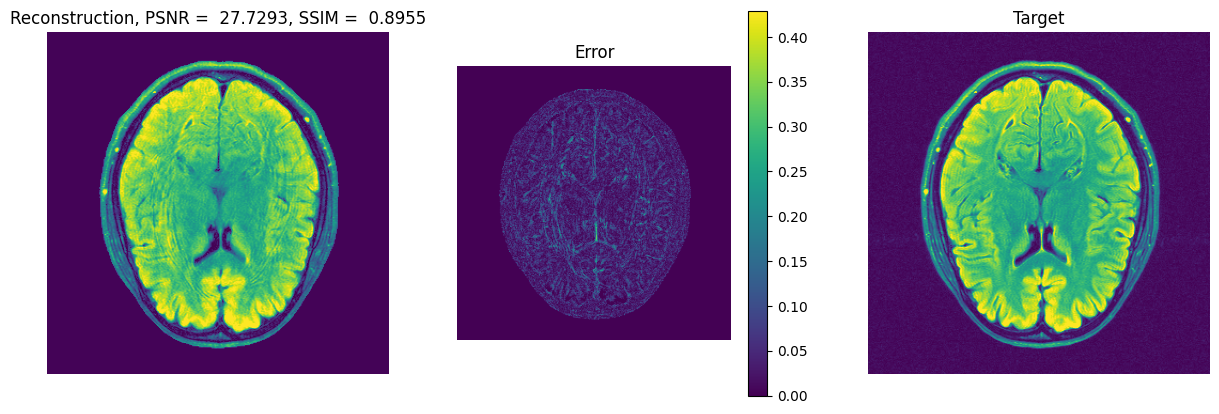

In [6]:
plot_rec(target_torch, L_x[-10], mask, err_with_mask = True, clip = True)

In [8]:
x_hat_fista, data_fidelity_vals, prior_vals, L_x = FISTA(images, physic_mcoil, stepsize=None, max_iter = 50, init_norm = True, kspace = y_hat, norm = True)

Iteration 49, criterion = 0.0001: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


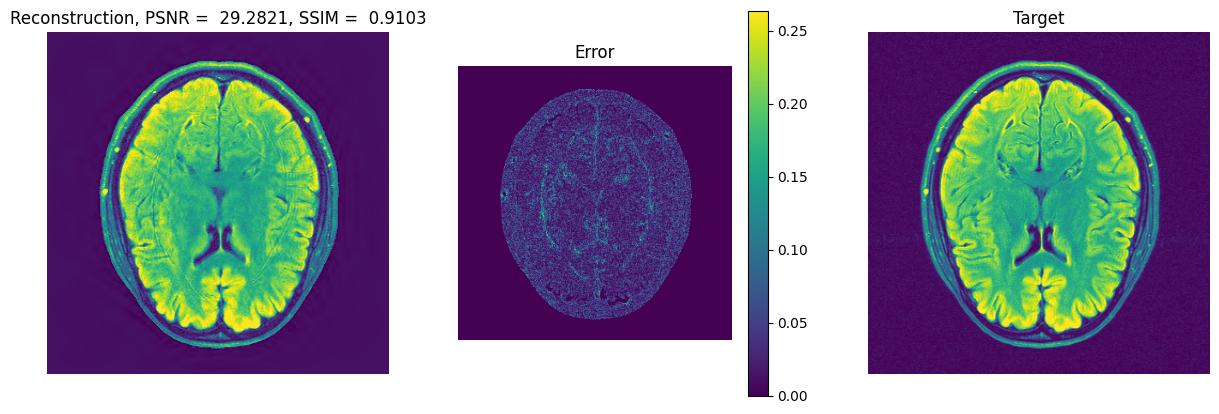

In [9]:
plot_rec(target_torch, L_x[-10], mask, err_with_mask = True, clip = True)

In [10]:
algo = get_model(max_iter = 30, stepsize = 1 / physic_mcoil.nufft.get_lipschitz_cst(max_iter = 20), sigma = 1e-3, norm = True)

with torch.no_grad():
    x_hat = algo(y_hat, physic_mcoil, compute_metrics = False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 